# Load files

In [51]:

import pandas as pd
import os
extracted_train_folder = 'extracted_train_data_files'
extracted_annonimized_folder = 'extracted_annonimized_files'
extracted_train_files = os.listdir(extracted_train_folder)
extracted_annonimized_files = os.listdir(extracted_annonimized_folder)
# Load the training data files
train_file_paths = [os.path.join(extracted_train_folder, file) for file in extracted_train_files]
train_dfs = {os.path.basename(path): pd.read_csv(path) for path in train_file_paths}

# Load the annonimized data
annonimized_df = pd.read_csv('extracted_annonimized_files/annonimized.csv')

# Load the student data
student_data_path = 'student.csv'
student_df = pd.read_csv(student_data_path)

# Display the first few rows of each DataFrame
for file_name, df in train_dfs.items():
    print(f"Data from {file_name}:")
    print(df.head(), "\n")

print("Annonimized data:")
print(annonimized_df.head(), "\n")

print("Student data:")
print(student_df.head(), "\n")

Data from ck-public.csv:
                                 student_id   CK
0  00b6dd4fc7eb817e03708c532016ef30ce564a61  5.5
1  00bef8afee8f3c595d535c9c03c490cac1a4f021  6.5
2  01122b3ef7e59b84189e65985305f575d6bdf83c  4.5
3  013de369c439ab0ead8aa7da64423aa395a8be39  5.0
4  014c59c6433fd764a0b08de6ffeb757eaf60aa73  4.0 

Data from qt-public.csv:
                                 student_id diemqt
0  00b6dd4fc7eb817e03708c532016ef30ce564a61    7.5
1  00bef8afee8f3c595d535c9c03c490cac1a4f021      7
2  01122b3ef7e59b84189e65985305f575d6bdf83c      9
3  013de369c439ab0ead8aa7da64423aa395a8be39     10
4  014c59c6433fd764a0b08de6ffeb757eaf60aa73      9 

Data from tbtl-public.csv:
                                 student_id  TBTL
0  00b6dd4fc7eb817e03708c532016ef30ce564a61  7.24
1  00bef8afee8f3c595d535c9c03c490cac1a4f021  8.11
2  01122b3ef7e59b84189e65985305f575d6bdf83c  7.30
3  0134f9f410c65ad0e8c2254a7e9288670e02a183  8.63
4  013de369c439ab0ead8aa7da64423aa395a8be39  8.20 

Data from th-publ

In [52]:
print(len(train_dfs))

4


# Feature engineering

In [76]:
# Convert submission and evaluation dates to datetime
annonimized_df = pd.read_csv('extracted_annonimized_files/annonimized.csv')

# annonimized_df['created_at'] = '2023-' + str(annonimized_df['created_at'])
# annonimized_df['updated_at'] = '2023-' + str(annonimized_df['updated_at']) 
# annonimized_df['created_at'] = pd.to_datetime(annonimized_df['created_at'], errors='ignore')
# annonimized_df['updated_at'] = pd.to_datetime(annonimized_df['updated_at'], errors='ignore')

# annonimized_df['submission_delay'] = (annonimized_df['updated_at'] - annonimized_df['created_at']).dt.total_seconds()
annonimized_df=annonimized_df.drop(columns=['problem_id','language_id'],axis=1)
# Aggregate features for each student
student_agg = annonimized_df.groupby('student_id').agg(
    total_submissions=('assignment_id', 'count'),
    avg_testcase_passed=('pre_score', 'mean'),
    max_testcase_passed=('pre_score', 'max'),
    min_testcase_passed=('pre_score', 'min'),
    status=('status', lambda x: (x=='SCORE').sum()),
    scored_submissions=('is_final', lambda x: (x == 1).sum()),
    late_submissions=('coefficient', lambda x: (x < 100).sum())
).reset_index()
student_agg.to_csv('all_student4.csv',index=False)

In [114]:
df=pd.read_csv('student_test_with_features.csv')
# Assuming `df` is your DataFrame containing the original features
df['success_rate'] = df['avg_testcase_passed'] / df['total_submissions']
df['scored_to_total_ratio'] = df['scored_submissions'] / df['total_submissions']
df['testcase_range'] = df['max_testcase_passed'] - df['min_testcase_passed']
df['total_testcases_passed'] = df[['avg_testcase_passed', 'max_testcase_passed', 'min_testcase_passed']].sum(axis=1)
df.to_csv('student_test_with_features.csv',index=False)

In [4]:
import featuretools as ft

# Create an entity set
es = ft.EntitySet(id='student')

# Assuming df is your DataFrame and it has an index column 'student_id'
es = es.entity_from_dataframe(entity_id='test_scores', dataframe=df, index='student_id')

# Run deep feature synthesis
feature_matrix, feature_defs = ft.dfs(entityset=es, target_entity='test_scores',
                                      max_depth=2)  # Adjust max_depth as needed

print(feature_matrix.head())

AttributeError: 'EntitySet' object has no attribute 'entity_from_dataframe'

In [78]:
all_student=pd.read_csv('all_student4.csv')
student_train=pd.read_csv('train_student.csv')
student_train=all_student.merge(student_train,on='student_id',how='right')
student_train.to_csv('student_train_with_features.csv',index=False)

In [77]:
all_student=pd.read_csv('all_student4.csv')
student_test=pd.read_csv('student_test.csv')
student_train=all_student.merge(student_test,on='student_id',how='right')
student_train.to_csv('student_test_with_features.csv',index=False)

In [249]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Corrected: Read the CSV file into a DataFrame
all_student_train = pd.read_csv('student_train_with_features.csv')
all_student_test = pd.read_csv('student_test_with_features.csv')

# Instantiate the LabelEncoder
encoder = LabelEncoder()

# Assuming you want to encode the 'some_column' column
# Replace 'some_column' with the actual column name you want to encode
all_student_train['student_id'] = encoder.fit_transform(all_student_train['student_id'])
all_student_test['student_id'] = encoder.fit_transform(all_student_test['student_id'])
all_student_train.to_csv('student_train_with_features_final.csv',index=False)
all_student_test.to_csv('student_test_with_features_final.csv',index=False)
# Now 'all_student' DataFrame has a new column 'some_column_encoded' with encoded values

In [79]:
import pandas as pd

# Combine the training data into a single DataFrame if necessary
student_train=pd.read_csv('student_train_with_features.csv')
ck=pd.read_csv('extracted_train_data_files\ck-public.csv')
student_train_score=student_train.merge(ck,on='student_id',how='inner')
student_train_score.to_csv('student_train_with_score.csv',index=False)
# for df in train_dfs.values():
#     student_train=student_train.merge(df,on='student_id',how='outer')
# student_train.to_csv('student_train_with_score.csv',index=False)

In [80]:
import pandas as pd

# Combine the training data into a single DataFrame if necessary
student_train=pd.read_csv('student_train_with_score.csv')
qt=pd.read_csv('extracted_train_data_files\qt-public.csv')
student_train_score=student_train.merge(qt,on='student_id',how='inner')
student_train_score.to_csv('student_train_with_score.csv',index=False)
# for df in train_dfs.values():
#     student_train=student_train.merge(df,on='student_id',how='outer')
# student_train.to_csv('student_train_with_score.csv',index=False)

In [81]:
import pandas as pd

# Combine the training data into a single DataFrame if necessary
student_train=pd.read_csv('student_train_with_score.csv')
tbtl=pd.read_csv('extracted_train_data_files/tbtl-public.csv')
student_train_score=student_train.merge(tbtl,on='student_id',how='inner')
student_train_score.to_csv('student_train_with_score.csv',index=False)
# for df in train_dfs.values():
#     student_train=student_train.merge(df,on='student_id',how='outer')
# student_train.to_csv('student_train_with_score.csv',index=False)

In [82]:
import pandas as pd

# Combine the training data into a single DataFrame if necessary
student_train=pd.read_csv('student_train_with_score.csv')
th=pd.read_csv('extracted_train_data_files/th-public.csv')
student_train_score=student_train.merge(th,on='student_id',how='inner')
student_train_score.to_csv('student_train_with_score.csv',index=False)
# for df in train_dfs.values():
#     student_train=student_train.merge(df,on='student_id',how='outer')
# student_train.to_csv('student_train_with_score.csv',index=False)

In [83]:
import numpy as np
# Merge with the aggregated annonimized data
student_train=pd.read_csv('student_train_with_score.csv')
feature=['diemqt','TH']
student_train[feature]=student_train[feature].replace('\xa0', 5)

# Handle missing values
student_train.fillna(5, inplace=True)

# Feature engineering (adjust based on actual features)
# Example: Create new features or transform existing ones if necessary

student_train.to_csv('training2.csv',index=False)


# Features

In [52]:
features = ['avg_testcase_passed','total_submissions' ,'max_testcase_passed', 'min_testcase_passed', 'scored_submissions', 'late_submissions','status','scored_to_total_ratio','total_testcases_passed','success_rate']
targets = ['diemqt', 'TBTL', 'TH']

In [260]:
print(len(features))

10


# Visualize


c:\Users\APTS\anaconda3\envs\myenv2\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x1500 with 0 Axes>

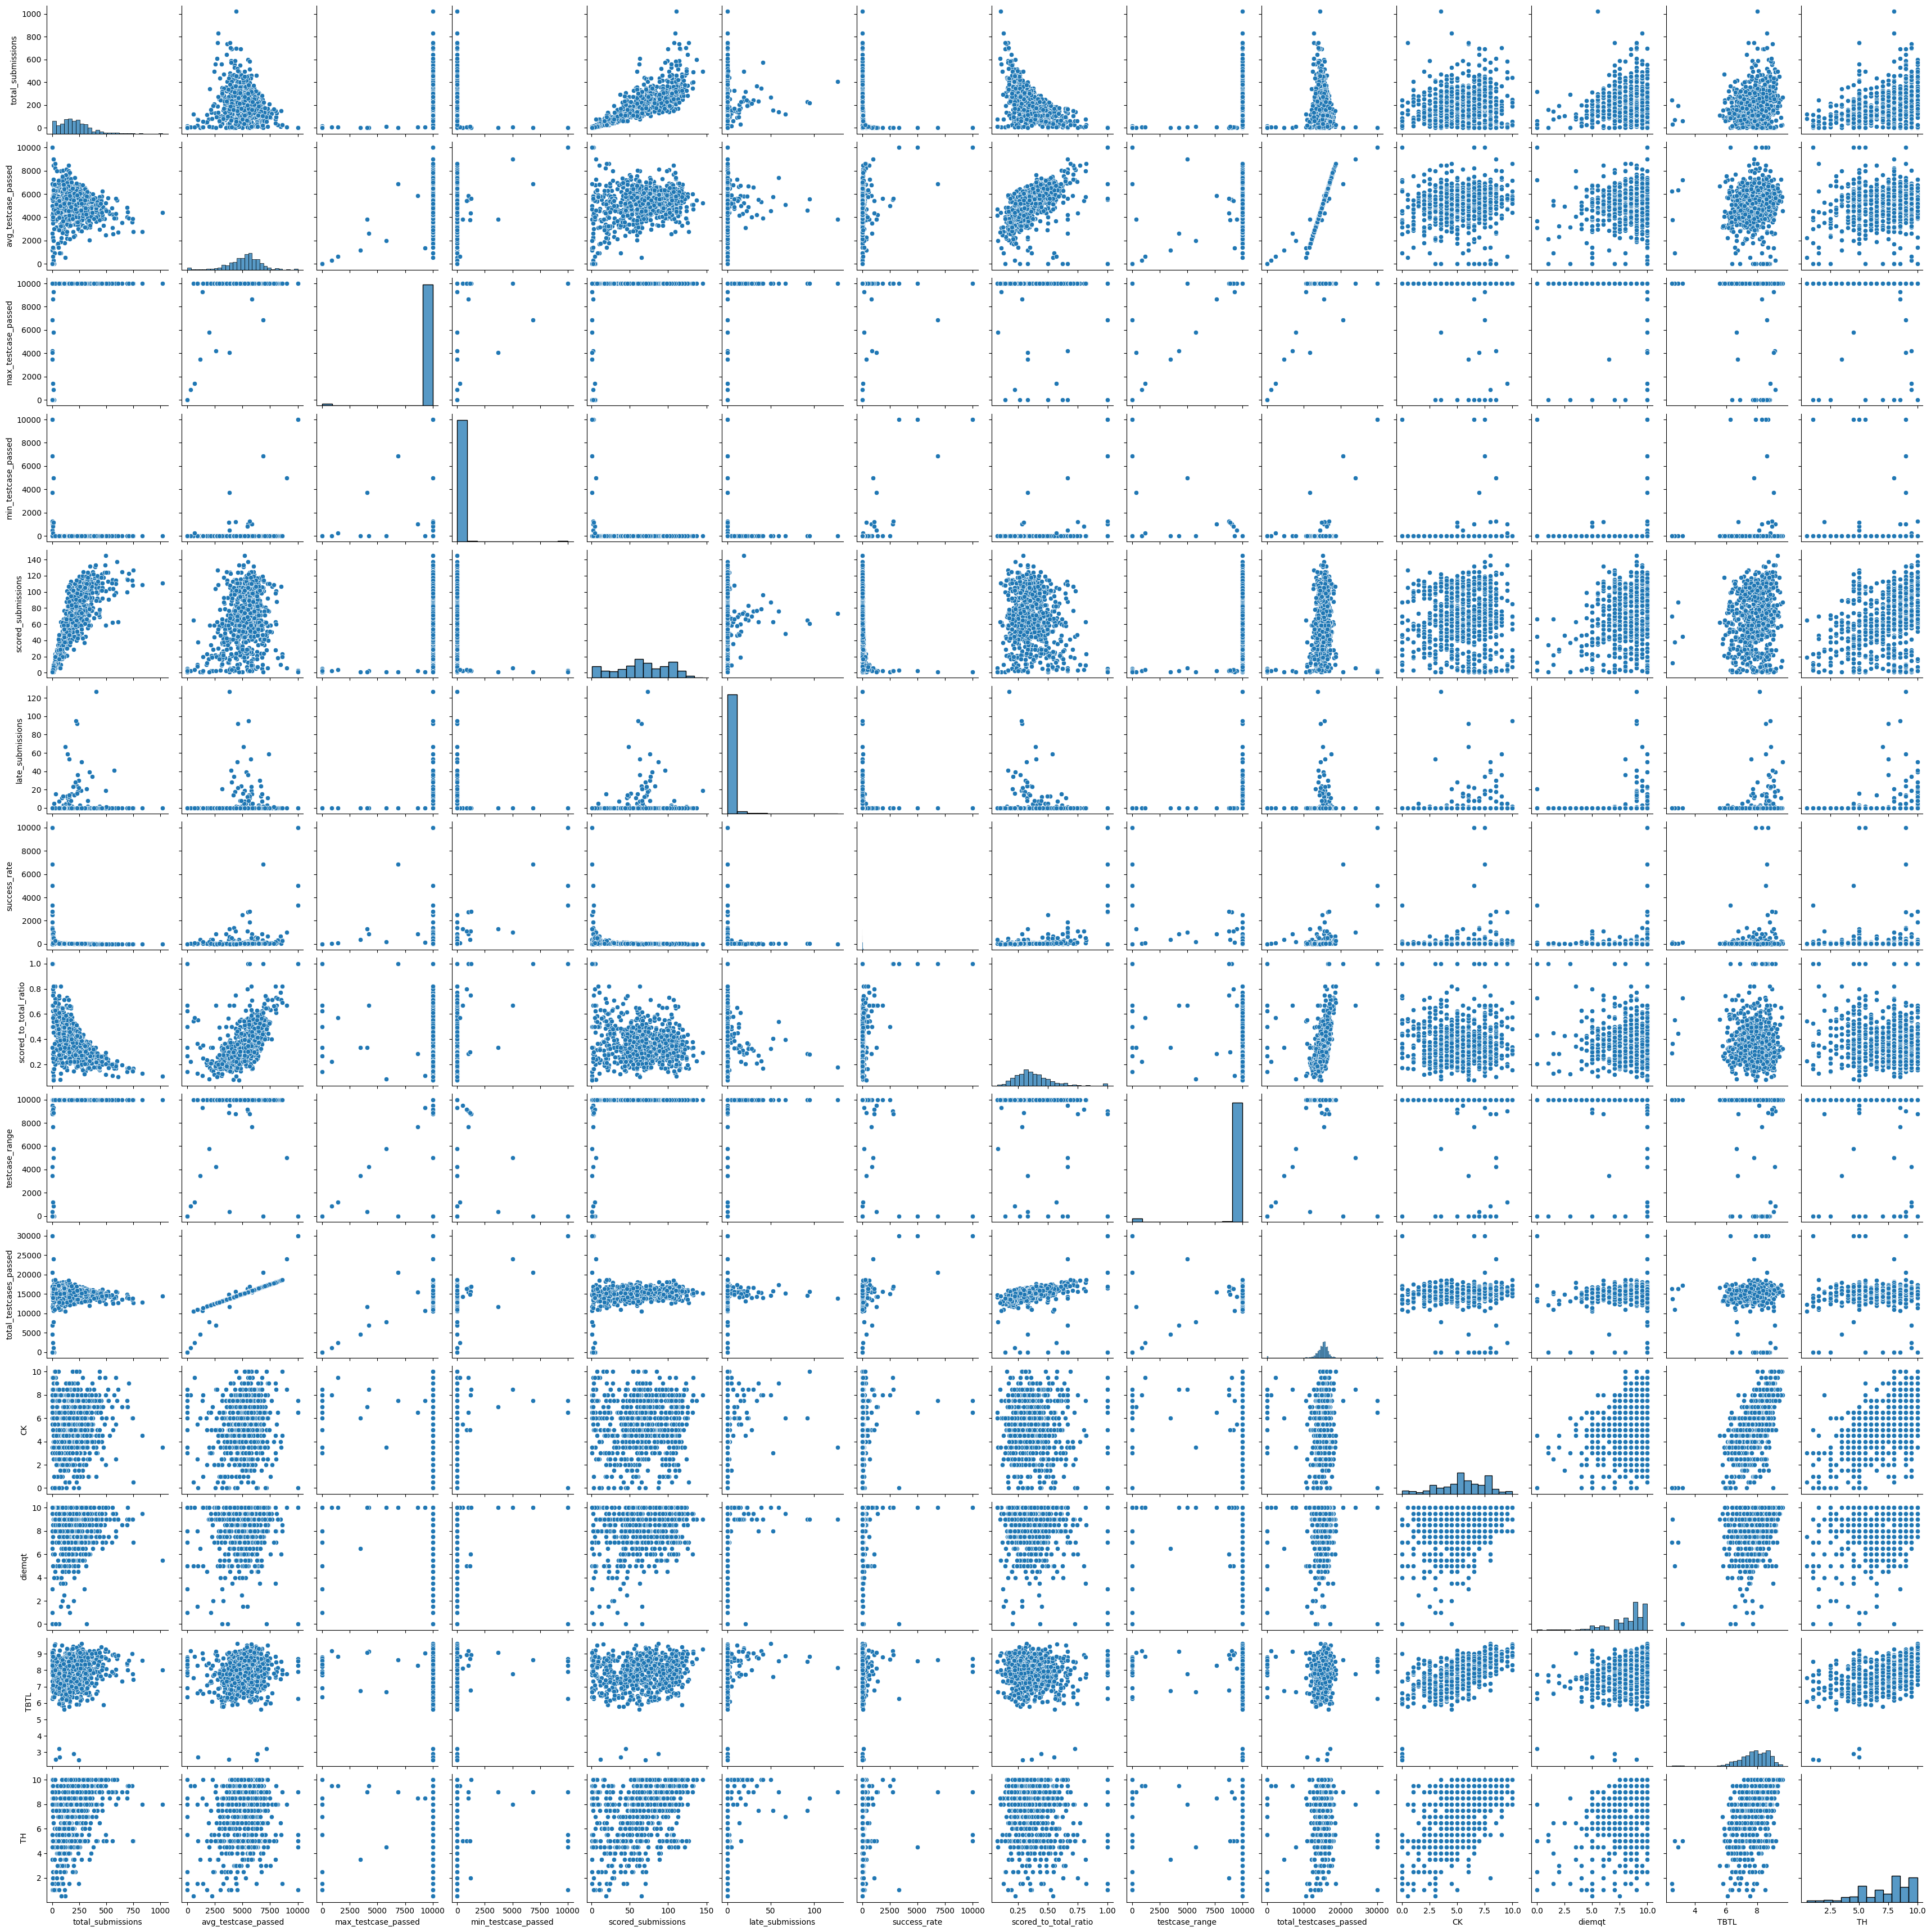

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df=pd.read_csv('training.csv')
plt.figure(figsize=(10,15))
sns.pairplot(df)
plt.show()

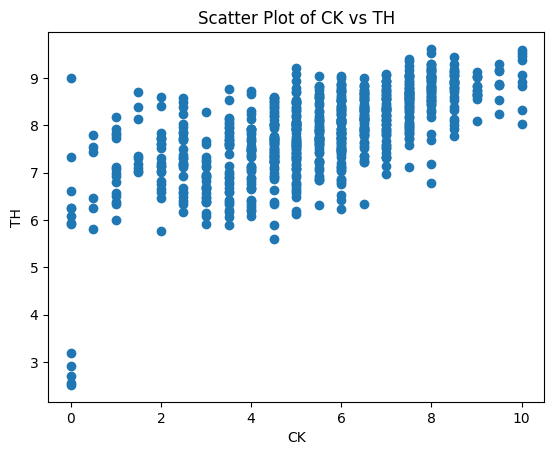

In [47]:
plt.scatter(df['CK'], df['TBTL'])
plt.xlabel('CK')
plt.ylabel('TH')
plt.title('Scatter Plot of CK vs TH')
plt.show()

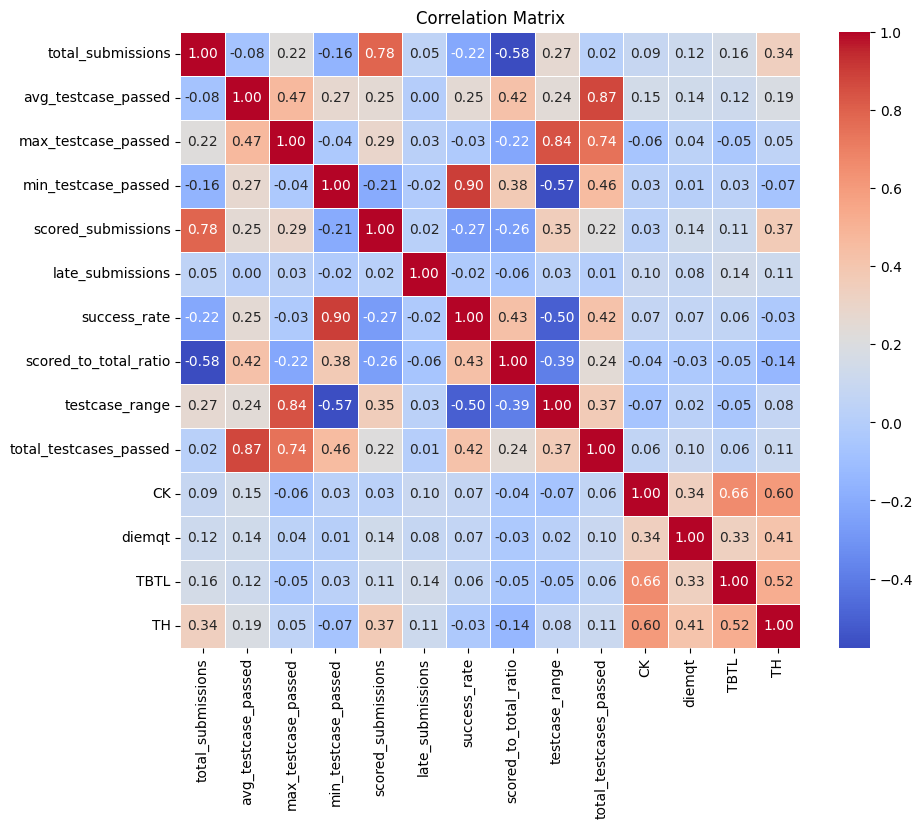

In [48]:
df=df.drop('student_id',axis=1)
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))  # Adjust the size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [131]:
import pandas as pd

student_test_with_features=pd.read_csv('student_test_with_features.csv')

# Read the files
result_th = pd.read_csv('result_th.csv')
result_tbtl = pd.read_csv('result_tbtl.csv')
result_ck = pd.read_csv('result_ck.csv')

# Extract the second column from each DataFrame
# Assuming the second column is at index 1
th_column = result_th.iloc[:, 1]
tbtl_column = result_tbtl.iloc[:, 1]
ck_column = result_ck.iloc[:, 1]

# Add these columns to the student_test_with_features DataFrame
student_test_with_features['result_th'] = th_column
student_test_with_features['result_tbtl'] = tbtl_column
student_test_with_features['result_ck'] = ck_column

# Save the updated DataFrame to a new file
student_test_with_features.to_csv('student_test_qt.csv', index=False)

In [ ]:
df=pd.read_csv('student_test_with_features.csv')


# Training Model


In [2]:
import pandas as pd

## Random forest

In [284]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import make_pipeline
import pandas as pd

merged_df = pd.read_csv('traning2.csv')
# Assuming 'features' and 'targets' are defined
X = merged_df[features]
y = merged_df[targets]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline that standardizes the data then applies RandomForestRegressor
model=RandomForestRegressor(n_estimators=1000,criterion='squared_error',max_depth=3,random_state=42)

pipeline = make_pipeline(StandardScaler(), model)

pipeline.fit(X_train, y_train)

# Predict on the test set using the pipeline
y_pred = pipeline.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
print(f'R^2 Score: {r2}')


R^2 Score: 0.1374923249351907


## SVR

In [266]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd

merged_df = pd.read_csv('traning2.csv')
# Assuming 'features' and 'targets' are defined
X = merged_df[features]
y = merged_df[targets]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline that standardizes the data then applies SVR
pipeline = make_pipeline(StandardScaler(), SVR())

# Train the model using the pipeline
pipeline.fit(X_train, y_train)

# Predict on the test set using the pipeline
y_pred = pipeline.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
print(f'R^2 Score: {r2}')

ValueError: y should be a 1d array, got an array of shape (608, 4) instead.

In [132]:
# Predict for the student data
import numpy as np
student_df=pd.read_csv('student_test_with_features.csv')

student_X = student_df[features]
predictions=pipeline.predict(student_X)
student_predictions = np.round_(predictions*2)/2

# Add predictions to the student DataFrame
student_df[targets] = student_predictions
# Save the predictions
student_df[['student_id', 'CK']].to_csv('result_ck.csv', index=False)
student_df[['student_id', 'diemqt']].to_csv('result_qt.csv', index=False)
student_df[['student_id', 'TBTL']].to_csv('result_tbtl.csv', index=False)
student_df[['student_id', 'TH']].to_csv('result_th.csv', index=False)
print(student_df.head())


                                 student_id  total_submissions  \
0  ed9eaeb6a707f50154024b24d7efcb874a9795dd                139   
1  ba12c0a2cb367af0467e479c03507c71a805d291                319   
2  b7298b0fe50443a623af9b56792b330c2d052845                247   
3  c60be70309789b39355dc612f36e37090ccad5dc                172   
4  a22a58c5be8aa2c2700619e37f2b7a6e4efa7e6b                288   

   avg_testcase_passed  max_testcase_passed  min_testcase_passed  status  \
0          5305.553957                10000                    0     105   
1          5228.576803                10000                    0     245   
2          5998.854251                10000                    0     211   
3          6237.773256                10000                    0     146   
4          5547.465278                10000                    0     250   

   scored_submissions  late_submissions  success_rate  scored_to_total_ratio  \
0                  58                 0     38.169453             

## Linear regression

In [80]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

merged_df = pd.read_csv('traning2.csv')
X = merged_df[features]
y = merged_df['diemqt']
model=LinearRegression()
# Creating a pipeline that first standardizes the data then applies Linear Regression
from sklearn.preprocessing import MinMaxScaler

# Assuming 'X' is your dataset excluding the target variable 'CK'
# Initialize MinMaxScaler with the desired feature range
scaler = MinMaxScaler(feature_range=(0, 10))

# Fit the scaler to your data and transform it
X_scaled = scaler.fit_transform(X)
best_r2=0
best_state=0
best_model=None
for i in range(50000,50000,10):
# Now, 'X_scaled' contains the scaled data with all features in the range 0 to 10
# You can proceed with splitting the data and training your model using 'X_scaled'
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=i)
    # Continue with your model training and evaluation as before
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    if(r2>best_r2):
        best_r2=r2
        best_state=i
        best_model=model
print(best_r2)
print(best_state)

0.16682228684998923
2560


In [58]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('traning2.csv')
# Assuming 'df' is your DataFrame
# Initialize MinMaxScaler with the desired feature range
scaler = MinMaxScaler(feature_range=(0, 10))

# Fit the scaler to your data and transform it
scaled_data = scaler.fit_transform(df[1:])

# Create a new DataFrame with the scaled data
df_scaled = pd.DataFrame(scaled_data, columns=[1:])
# Now, 'df_scaled' contains the scaled data with all features in the range 0 to 10

ValueError: could not convert string to float: '83e4ca230ab9b35d221d09d335850af44966b772'

In [51]:
print(df['total_submissions'].dtype)

int64


In [33]:
# Predict for the student data
import numpy as np
student_df=pd.read_csv('student_test_with_features.csv')

student_X = student_df[features]
predictions=pipeline.predict(student_X)
student_predictions = np.round_(predictions*2)/2

# Add predictions to the student DataFrame
student_df['TBTL'] = student_predictions
# Save the predictions
#student_df[['student_id', 'CK']].to_csv('result_ck.csv', index=False)
#student_df[['student_id', 'diemqt']].to_csv('result_qt.csv', index=False)
#student_df[['student_id', 'TBTL']].to_csv('result_tbtl.csv', index=False)
student_df[['student_id', 'TBTL']].to_csv('result_tbtl.csv', index=False)
print(student_df.head())


                                 student_id  total_submissions  \
0  ed9eaeb6a707f50154024b24d7efcb874a9795dd                139   
1  ba12c0a2cb367af0467e479c03507c71a805d291                319   
2  b7298b0fe50443a623af9b56792b330c2d052845                247   
3  c60be70309789b39355dc612f36e37090ccad5dc                172   
4  a22a58c5be8aa2c2700619e37f2b7a6e4efa7e6b                288   

   avg_testcase_passed  max_testcase_passed  min_testcase_passed  status  \
0          5305.553957                10000                    0     105   
1          5228.576803                10000                    0     245   
2          5998.854251                10000                    0     211   
3          6237.773256                10000                    0     146   
4          5547.465278                10000                    0     250   

   scored_submissions  late_submissions  success_rate  scored_to_total_ratio  \
0                  58                 0     38.169453             

## DEEP LEARNING


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

merged_df = pd.read_csv('training.csv')
X = merged_df[features]
y = merged_df[targets]

# Creating a pipeline that first standardizes the data then applies Linear Regression
pipeline = make_pipeline(StandardScaler(), LinearRegression())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model using the pipeline
pipeline.fit(X_train, y_train)

# Making predictions using the pipeline
y_pred = pipeline.predict(X_test)

# Evaluating the model
mse = r2_score(y_test, y_pred)
print(f"R_2 Error: {mse}")

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import r2_score

# Load data
merged_df = pd.read_csv('training.csv')
features = merged_df.drop('diemqt', axis=1)
target = merged_df['diemqt']

# Preprocess data: Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split data
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
mse = r2_score(y_test, y_pred)
print(f"R_2 Score: {mse}")

ValueError: could not convert string to float: '0bd2037bf68a97753e5e67ab55dac026a649f279'

In [20]:
# Predict for the student data
import numpy as np
student_df=pd.read_csv('student_test_with_features.csv')

student_X = student_df[features]
predictions=model.predict(student_X)
student_predictions = np.round_(predictions*2)/2

# Add predictions to the student DataFrame
student_df[targets] = student_predictions
# Save the predictions
student_df[['student_id', 'CK']].to_csv('result_ck.csv', index=False)
student_df[['student_id', 'diemqt']].to_csv('result_qt.csv', index=False)
student_df[['student_id', 'TBTL']].to_csv('result_tbtl.csv', index=False)
student_df[['student_id', 'TH']].to_csv('result_th.csv', index=False)
print(student_df.head())


                                 student_id  total_submissions  \
0  ed9eaeb6a707f50154024b24d7efcb874a9795dd                139   
1  ba12c0a2cb367af0467e479c03507c71a805d291                319   
2  b7298b0fe50443a623af9b56792b330c2d052845                247   
3  c60be70309789b39355dc612f36e37090ccad5dc                172   
4  a22a58c5be8aa2c2700619e37f2b7a6e4efa7e6b                288   

   avg_testcase_passed  max_testcase_passed  min_testcase_passed  \
0          5305.553957                10000                    0   
1          5228.576803                10000                    0   
2          5998.854251                10000                    0   
3          6237.773256                10000                    0   
4          5547.465278                10000                    0   

   scored_submissions  late_submissions  success_rate  scored_to_total_ratio  \
0                  58                 0     38.169453               0.417266   
1                 117             

## LightGBM


In [225]:
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

# Load dataset
merged_df = pd.read_csv('traning2.csv')

# Assuming 'features' is a list of column names for features
# and 'target' is the name of the single target column
X = merged_df[features]
y = merged_df['diemqt']  # Corrected to refer to a single column name

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the scaled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

parameters = {
    'objective': 'regression',
    'metric': 'r2',
    'num_leaves': 30,
    'learning_rate': 0.01,
    'feature_fraction': 0.8
}

model = lgb.train(parameters, train_data, valid_sets=[test_data], num_boost_round=100)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R2 Score: {r2}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1319
[LightGBM] [Info] Number of data points in the train set: 608, number of used features: 8
[LightGBM] [Info] Start training from score 8.257401
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [217]:
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Load dataset
merged_df = pd.read_csv('traning2.csv')

# Assuming 'features' is a list of column names for features
# and 'target' is the name of the single target column
X = merged_df[features]
y = merged_df[targets]  # Corrected to refer to a single column name

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

parameters = {
    'objective': 'regression',
    'metric': 'r2',
    'num_leaves': 30,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

model = lgb.train(parameters, train_data, valid_sets=[test_data], num_boost_round=200)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R2 Score: {r2}")

ValueError: DataFrame for label cannot have multiple columns

##


In [67]:
import numpy as np
student_df=pd.read_csv('student_test_qt.csv')
student_X = student_df[features]
student_predictions=model.predict(student_X)
student_predictions=np.round_(student_predictions*2)/2
# Add predictions to the student DataFrame
student_df['diemqt'] = student_predictions
# Save the predictions
#student_df[['student_id', 'CK']].to_csv('result_ck.csv', index=False)
student_df[['student_id', 'diemqt']].to_csv('result_qt.csv', index=False)
#student_df[['student_id', 'TBTL']].to_csv('result_tbtl.csv', index=False)
#student_df[['student_id', 'TH']].to_csv('result_th.csv', index=False)
print(student_df.head())


                                 student_id  total_submissions  \
0  ed9eaeb6a707f50154024b24d7efcb874a9795dd                139   
1  ba12c0a2cb367af0467e479c03507c71a805d291                319   
2  b7298b0fe50443a623af9b56792b330c2d052845                247   
3  c60be70309789b39355dc612f36e37090ccad5dc                172   
4  a22a58c5be8aa2c2700619e37f2b7a6e4efa7e6b                288   

   avg_testcase_passed  max_testcase_passed  min_testcase_passed  \
0          5305.553957                10000                    0   
1          5228.576803                10000                    0   
2          5998.854251                10000                    0   
3          6237.773256                10000                    0   
4          5547.465278                10000                    0   

   scored_submissions  late_submissions  success_rate  scored_to_total_ratio  \
0                  58                 0     38.169453               0.417266   
1                 117             

## XG BOOST

In [2]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score  # For classification
from sklearn.metrics import r2_score  # For regression
import pandas as pd

merged_df = pd.read_csv('traning2.csv')
X = merged_df[features]
y = merged_df['diemqt']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = xgb.XGBRegressor(
    max_depth=5,  # Increased from 3 to allow capturing more complex relationships
    min_child_weight=1,
    learning_rate=0.005,  # Decreased to make the model learn slower
    n_estimators=1000,  # Increased to give the model more capacity to learn
    objective='reg:squarederror',
    gamma=0.4,  # Increased to make the model more conservative
    subsample=0.8,  # Slightly increased
    colsample_bytree=0.9  # Slightly increased
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R2 Score: {r2}")


R2 Score: 0.04927543714496141


In [178]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import r2_score
import xgboost as xgb
import pandas as pd

# Load data
merged_df = pd.read_csv('traning2.csv')
X = merged_df[features]  # Ensure 'features' is defined
y = merged_df[targets]  # Ensure 'targets' is defined

# Define model
model = xgb.XGBRegressor(objective='reg:squarederror')

# Parameters grid
param_grid = {
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Cross-validation and grid search
kf = KFold(n_splits=3, shuffle=True, random_state=42)
grid_search = GridSearchCV(model, param_grid, scoring='r2', cv=kf, verbose=1, n_jobs=-1)
grid_search.fit(X, y)

# Best model
best_model = grid_search.best_estimator_

# Predict and evaluate
y_pred = best_model.predict(X)
r2 = r2_score(y, y_pred)
print(f"Best R2 Score: {r2}")
print(f"Best Parameters: {grid_search.best_params_}")

Fitting 3 folds for each of 2187 candidates, totalling 6561 fits


KeyboardInterrupt: 

## diemqt

In [288]:
# Predict for the student data
import numpy as np
student_df=pd.read_csv('student_test_with_features.csv')

student_X = student_df[features]
predictions=model.predict(student_X)

# Add predictions to the student DataFrame
student_df[targets] = predictions
student_df[['student_id', 'CK']].to_csv('result_ck.csv', index=False)
student_df[['student_id', 'diemqt']].to_csv('result_qt.csv', index=False)
student_df[['student_id', 'TBTL']].to_csv('result_tbtl.csv', index=False)
student_df[['student_id', 'TH']].to_csv('result_th.csv', index=False)
print(student_df.head())


                                 student_id  total_submissions  \
0  ed9eaeb6a707f50154024b24d7efcb874a9795dd                139   
1  ba12c0a2cb367af0467e479c03507c71a805d291                319   
2  b7298b0fe50443a623af9b56792b330c2d052845                247   
3  c60be70309789b39355dc612f36e37090ccad5dc                172   
4  a22a58c5be8aa2c2700619e37f2b7a6e4efa7e6b                288   

   avg_testcase_passed  max_testcase_passed  min_testcase_passed  status  \
0          5305.553957                10000                    0     105   
1          5228.576803                10000                    0     245   
2          5998.854251                10000                    0     211   
3          6237.773256                10000                    0     146   
4          5547.465278                10000                    0     250   

   scored_submissions  late_submissions  success_rate  scored_to_total_ratio  \
0                  58                 0     38.169453             

## Elastice Net

In [41]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV,ElasticNet
from sklearn.metrics import r2_score
import pandas as pd

# Assuming 'features' and 'targets' are defined and 'training.csv' is your dataset
merged_df = pd.read_csv('traning2.csv')

X = merged_df[features]
# Ensure y is a 2D array for multi-task. Each column should represent a different target.
y = merged_df['diemqt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use ElasticNetCV for multi-task regression
elastic_net_cv = ElasticNetCV(cv=5, random_state=42, l1_ratio=[.1, .5, .7, .9, .95, .99, 1])
elastic_net_cv.fit(X_train, y_train)
y_pred = elastic_net_cv.predict(X_test)

# Assuming mean_squared_error is already imported or defined
print(f"Best alpha: {elastic_net_cv.alpha_}")
print(f"Best l1_ratio: {elastic_net_cv.l1_ratio_}")

model = ElasticNet(alpha=elastic_net_cv.alpha_, l1_ratio=elastic_net_cv.l1_ratio_)
model.fit(X_train, y_train)
# Calculate R2 score for each output
r2_scores = r2_score(y_test, y_pred)
print(f"R2 Scores: {r2_scores}")

Best alpha: 0.6534442989161483
Best l1_ratio: 1.0
R2 Scores: 0.013184289200446453


c:\Users\APTS\anaconda3\envs\myenv2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.590e+01, tolerance: 1.911e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\APTS\anaconda3\envs\myenv2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.590e+01, tolerance: 1.911e-01
  model = cd_fast.enet_coordinate_descent(


In [22]:
# Predict for the student data
import numpy as np
student_df=pd.read_csv('student_test_with_features.csv')

student_X = student_df[features]
predictions=model.predict(student_X)
student_predictions = np.round_(predictions*2)/2

# Add predictions to the student DataFrame
student_df[targets] = student_predictions
# Save the predictions
student_df[['student_id', 'CK']].to_csv('result_ck.csv', index=False)
student_df[['student_id', 'diemqt']].to_csv('result_qt.csv', index=False)
student_df[['student_id', 'TBTL']].to_csv('result_tbtl.csv', index=False)
student_df[['student_id', 'TH']].to_csv('result_th.csv', index=False)
print(student_df.head())


                                 student_id  total_submissions  \
0  ed9eaeb6a707f50154024b24d7efcb874a9795dd                139   
1  ba12c0a2cb367af0467e479c03507c71a805d291                319   
2  b7298b0fe50443a623af9b56792b330c2d052845                247   
3  c60be70309789b39355dc612f36e37090ccad5dc                172   
4  a22a58c5be8aa2c2700619e37f2b7a6e4efa7e6b                288   

   avg_testcase_passed  max_testcase_passed  min_testcase_passed  \
0          5305.553957                10000                    0   
1          5228.576803                10000                    0   
2          5998.854251                10000                    0   
3          6237.773256                10000                    0   
4          5547.465278                10000                    0   

   scored_submissions  late_submissions  success_rate  scored_to_total_ratio  \
0                  58                 0     38.169453               0.417266   
1                 117             

## SVM


In [48]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd

merged_df = pd.read_csv('traning2.csv')
# Assuming 'features' and 'targets' are defined
X = merged_df[features]
y = merged_df['TH']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline that standardizes the data then applies SVR
model = make_pipeline(StandardScaler(), SVR())
model.fit(X_train, y_train)

# Predict on the test set using the pipeline
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
print(f'R^2 Score: {r2}')

R^2 Score: 0.28229203527791136


In [5]:
import pandas as pd
 
student_train=pd.read_csv('training.csv')
# Assuming student_train is already loaded as shown in the excerpt
for column in student_train.columns:
    print(f"Unique values in '{column}': {student_train[column].nunique()}")

Unique values in 'student_id': 761
Unique values in 'total_submissions': 377
Unique values in 'avg_testcase_passed': 745
Unique values in 'max_testcase_passed': 11
Unique values in 'min_testcase_passed': 12
Unique values in 'scored_submissions': 130
Unique values in 'late_submissions': 33
Unique values in 'success_rate': 748
Unique values in 'scored_to_total_ratio': 663
Unique values in 'testcase_range': 17
Unique values in 'total_testcases_passed': 746
Unique values in 'CK': 21
Unique values in 'diemqt': 20
Unique values in 'TBTL': 288
Unique values in 'TH': 20


# Draw result

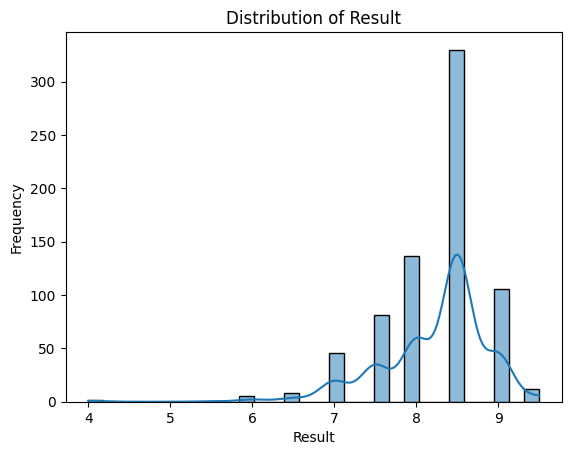

In [231]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'df' is your DataFrame and 'result' is the column of interest
# Replace 'df' and 'result' with your actual DataFrame and column name

# Load your data
df = pd.read_csv('result_qt.csv')  # Uncomment and modify this line as necessary

# Plotting the distribution of 'result'
sns.histplot(df['diemqt'], kde=True, bins=30)
plt.title('Distribution of Result')
plt.xlabel('Result')
plt.ylabel('Frequency')
plt.show()

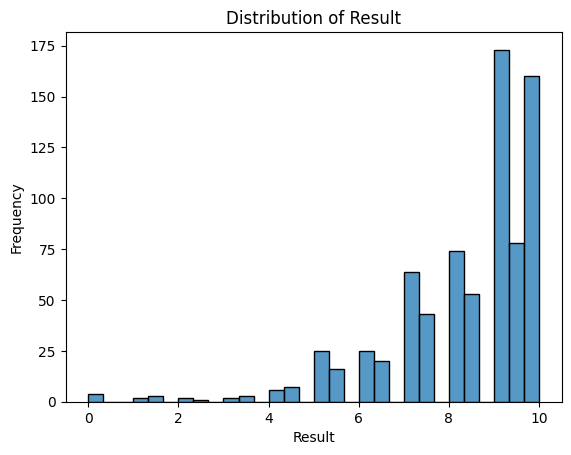

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'df' is your DataFrame and 'result' is the column of interest
# Replace 'df' and 'result' with your actual DataFrame and column name

# Load your data
df = pd.read_csv('training2.csv')  # Uncomment and modify this line as necessary
# Plotting the distribution of 'result'
sns.histplot(df['diemqt'], kde=False, bins=30)
plt.title('Distribution of Result')
plt.xlabel('Result')
plt.ylabel('Frequency')
plt.show()

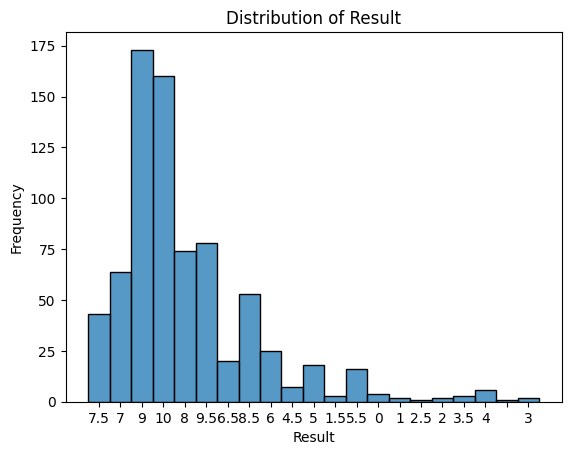

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load your data
df = pd.read_csv('extracted_train_data_files\qt-public.csv')

# Sort the DataFrame by 'diemqt' column
# Plotting the distribution of 'diemqt' after sorting
sns.histplot(df['diemqt'], kde=False, bins=30)
plt.title('Distribution of Result')
plt.xlabel('Result')
plt.ylabel('Frequency')
plt.show()